# A Beginner-Friendly PyTorch Tutorial: Build and Train Your First Model

This is the accompanying notebook for my [blog post](https://huggingface.co/blog/dvgodoy/beginner-pytorch-tutorial) published on Hugging Face

## Data Generation

In [1]:
import numpy as np

# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]


## Linear Regression in Numpy

In [2]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)  # Line 3
b = np.random.randn(1)  # Line 4

print(a, b)

# Sets learning rate
lr = 1e-1               # Line 9
# Defines number of epochs
n_epochs = 1000         # Line 11

for epoch in range(n_epochs):
    # Step 1: Computes our model's predicted output
    yhat = a + b * x_train      # Line 15
    # Step 2
    # How wrong is our model? That's the error!
    error = (y_train - yhat)    # Line 18
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()  # Line 20
    # Step 3
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()             # Line 23
    b_grad = -2 * (x_train * error).mean() # Line 24
    # Step 4
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad   # Line 27
    b = b - lr * b_grad   # Line 28

print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])

[0.49671415] [-0.1382643]
[1.02354094] [1.96896411]
[1.02354075] [1.96896447]


## PyTorch

### Loading Data, Devices, and CUDA

In [9]:
!pip install torchviz

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


### Creating Parameters

In [4]:
# We can specify the device at the moment of creation - RECOMMENDED!
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)


### Autograd

In [5]:
lr = 1e-1
n_epochs = 1000

torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

for epoch in range(n_epochs):
    # Step 1
    yhat = a + b * x_train_tensor
    # Step 2
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    # No more manual computation of gradients!
    # a_grad = -2 * error.mean()
    # b_grad = -2 * (x_tensor * error).mean()

    # Step 3
    # We just tell PyTorch to work its way BACKWARDS from the specified loss!
    loss.backward()
    # Let's check the computed gradients...
    # print(a.grad)
    # print(b.grad)

    # What about UPDATING the parameters? Not so fast...

    # FIRST ATTEMPT
    # AttributeError: 'NoneType' object has no attribute 'zero_'
    # a = a - lr * a.grad
    # b = b - lr * b.grad
    # print(a)

    # SECOND ATTEMPT
    # RuntimeError: a leaf Variable that requires grad has been used in an in-place operation.
    # a -= lr * a.grad
    # b -= lr * b.grad

    # THIRD ATTEMPT
    # We need to use NO_GRAD to keep the update out of the gradient computation
    # Why is that? It boils down to the DYNAMIC GRAPH that PyTorch uses...
    # Step 4
    with torch.no_grad():
        a -= lr * a.grad
        b -= lr * b.grad

    # PyTorch is "clingy" to its computed gradients, we need to tell it to let it go...
    a.grad.zero_()
    b.grad.zero_()

print(a, b)

tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


### Dynamic Computation Graph

In [6]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

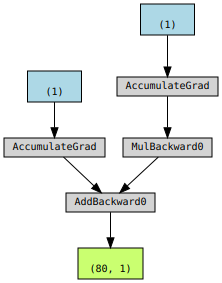

In [7]:
from torchviz import make_dot
make_dot(yhat)

In [8]:
a.requires_grad_(False)
yhat = a + b * x_train_tensor

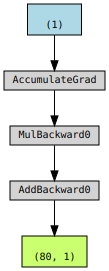

In [9]:
make_dot(yhat)

## Optimizer

In [10]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    # Step 1
    yhat = a + b * x_train_tensor
    # Step 2
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()
    # Step 3
    loss.backward()

    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    # Step 4
    optimizer.step()

    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()

print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## Loss

In [11]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([a, b], lr=lr)

for epoch in range(n_epochs):
    # Step 1
    yhat = a + b * x_train_tensor
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    # Step 2
    loss = loss_fn(y_train_tensor, yhat)   # Line 20
    # Step 3
    loss.backward()
    # Step 4
    optimizer.step()
    optimizer.zero_grad()

print(a, b)

tensor([0.1940], device='cuda:0', requires_grad=True) tensor([0.1391], device='cuda:0', requires_grad=True)
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


## Model

In [12]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "a" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x):
        # Computes the outputs / predictions
        return self.a + self.b * x

In [13]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    # Step 1
    yhat = model(x_train_tensor)
    # Step 2
    loss = loss_fn(y_train_tensor, yhat)
    # Step 3
    loss.backward()
    # Step 4
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('a', tensor([0.3367], device='cuda:0')), ('b', tensor([0.1288], device='cuda:0'))])
OrderedDict([('a', tensor([1.0235], device='cuda:0')), ('b', tensor([1.9690], device='cuda:0'))])


### Nested Models

In [14]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)

### Sequential Models

In [15]:
# Alternatively, you can use a Sequential model
model = nn.Sequential(nn.Linear(1, 1)).to(device)

## Training Step

In [18]:
def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Step 1: Makes predictions
        yhat = model(x)
        # Step 2: Computes loss
        loss = loss_fn(y, yhat)
        # Step 3: Computes gradients
        loss.backward()
        # Step 4: Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()

    # Returns the function that will be called inside the train loop
    return train_step

# Starts from scratch
lr = 1e-1
n_epochs = 1000
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = []

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)

# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


## Dataset

In [19]:
from torch.utils.data import Dataset, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)

# Wait, is this a CPU tensor now? Why? Where is .to(device)?
x_train_tensor = torch.from_numpy(x_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

train_data = TensorDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))
(tensor([0.7713]), tensor([2.4745]))


### DataLoader

In [20]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [21]:
next(iter(train_loader))

[tensor([[0.1834],
         [0.0452],
         [0.8022],
         [0.1395],
         [0.7132],
         [0.4722],
         [0.0885],
         [0.0055],
         [0.6011],
         [0.7320],
         [0.5979],
         [0.4952],
         [0.8084],
         [0.8324],
         [0.3309],
         [0.3745]]),
 tensor([[1.4637],
         [0.9985],
         [2.6229],
         [1.3051],
         [2.6162],
         [1.9857],
         [1.0708],
         [1.0632],
         [2.1214],
         [2.4732],
         [2.0407],
         [1.8735],
         [2.6141],
         [2.6119],
         [1.5427],
         [1.7578]])]

In [22]:
# Starts from scratch
lr = 1e-1
n_epochs = 1000
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9704]], device='cuda:0')), ('0.bias', tensor([1.0255], device='cuda:0'))])


### Random Split

In [23]:
from torch.utils.data.dataset import random_split

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(dataset=train_dataset, batch_size=16)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

## Evaluation

In [24]:
# Starts from scratch
lr = 1e-1
n_epochs = 1000
model = nn.Sequential(nn.Linear(1, 1)).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

losses = []
val_losses = []
train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(n_epochs):
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        loss = train_step(x_batch, y_batch)
        losses.append(loss)

    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            # Evaluation only performs Steps 1 and 2
            model.eval()
            # Step 1
            yhat = model(x_val)              # Line 20
            # Step 2
            val_loss = loss_fn(y_val, yhat)  # Line 22
            val_losses.append(val_loss.item())

print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9494]], device='cuda:0')), ('0.bias', tensor([1.0262], device='cuda:0'))])
